In this notebook I will try to experiment with techniques and algorithms to find best solution.

#### Import

In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.base import clone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#### Constants

In [2]:
DATA_DIR = "data"
CHALLENGE_DATA_FILENAME = "data.csv"

SEED = 2018

### I/O

In [3]:
def load(file_dir, file_name):
    filepath = os.path.join(file_dir, file_name)
    return pd.read_csv(filepath, sep=",")

def save_sklearn_model(clf, filepath):
    joblib.dump(clf, filepath) 
    
def load_sklearn_model(filepath):
    return joblib.load(filepath)

### Preprocessing

In [4]:
def add_feature_file_body_length(df):
    df_cpy = df.copy()
    df_cpy["file_body_length"] = df_cpy["file_body"].apply(lambda x: len(x))
    return df_cpy

def add_feature_encode(df, target_feature, label_encoder):
    df_cpy = df.copy()
    df_cpy[target_feature] = label_encoder.fit_transform(df_cpy[target_feature])
    return df_cpy

def remove_short_files(df, min_character_count=15):
    return df.loc[df["file_body_length"] > min_character_count]

def remove_empty_files(df):
    return df[~df["file_body"].isnull()]    

### Train/Val/Test Building

In [5]:
def split_into_stratified_test_set(df, target_value_col, frac=0.25):
    df_samples = None
    for class_name in df[target_value_col].unique():
        df_part = df.loc[df[target_value_col] == class_name]
        df_part = df_part.sample(frac=frac, random_state=SEED)
        
        if df_samples is None:
            df_samples = df_part
        else:
            df_samples = pd.concat([df_samples, df_part], axis=0)
    
    return df.loc[~df.index.isin(df_samples.index)], df_samples

def tokenize(df_train, df_test, text_feature, tokenizer):
    X_train_tokenized = tokenizer.fit_transform(df_train[text_feature])
    X_test_tokenized = tokenizer.transform(df_test[text_feature])
    return X_train_tokenized, X_test_tokenized

def extract_targets(df_train, df_test, target_value_col):
    return df_train[target_value_col], df_test[target_value_col]

### Evaluation

In [6]:
def plot_confusion_matrix(y_test, y_pred, classes, cmap=plt.cm.Blues,
                          title="Programming Languages Classification"):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

### Pipelines

In [7]:
def ml_preprocess(df, text_feature, target_feature, label_encoder, tokenizer):
    df_preprocessed = remove_empty_files(df)
    df_preprocessed = add_feature_file_body_length(df_preprocessed)
    df_preprocessed = remove_short_files(df_preprocessed)
    df_preprocessed = add_feature_encode(df_preprocessed, target_feature, label_encoder)
    
    df_train, df_test = split_into_stratified_test_set(df_preprocessed, target_feature)
    
    X_train, X_test = tokenize(df_train, df_test, text_feature, tokenizer)
    y_train, y_test = extract_targets(df_train, df_test, target_feature)
    
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)

    return X_train, y_train, X_test, y_test
   
def train_optimize_and_predict(X_train, y_train, X_test, y_test, model_template,
                               metric, optimization, param_space, show_confusion_matrix,
                               label_encoder):
    
    metric_scorer = make_scorer(metric, average="micro")
    
    optimizer = optimization(model_template, param_space, scoring=metric_scorer, 
                             cv=3, verbose=1)
    optimizer.fit(X_train, y_train)
    
    model = optimizer.best_estimator_
    print(" - best parameters: {}".format(model))
    
    train_pred = model.predict(X_train)
    train_score = metric(train_pred, y_train, average="micro")
    
    test_pred = model.predict(X_test)
    test_score = metric(test_pred, y_test, average="micro")
    
    print(" - f1_score on train set: {}".format(train_score))
    print(" - f1_score on test set: {}".format(test_score))
    
    if show_confusion_matrix:
        plot_confusion_matrix(y_test, test_pred, label_encoder.classes_)
        
    return model

def train_and_predict(X_train, y_train, X_test, y_test, model_template, metric,
                      optimization, param_space, show_confusion_matrix, label_encoder):
    
    model = clone(model_template)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    train_score = metric(train_pred, y_train, average="micro")
    
    test_pred = model.predict(X_test)
    test_score = metric(test_pred, y_test, average="micro")
    
    print(" - f1_score on train set: {}".format(train_score))
    print(" - f1_score on test set: {}".format(test_score))
    
    if show_confusion_matrix:
        plot_confusion_matrix(y_test, test_pred, label_encoder.classes_)
        
    return model

### Experiment setup

In [8]:
experiment_space = [
    {
        "name": "naive_bayes_cv_maxfeatures10000_mindf15_ngram11", 
        "model_template": MultinomialNB(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "naive_bayes_tfidf_maxfeatures10000_mindf15_ngram11", 
        "model_template": MultinomialNB(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": TfidfVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "logistic_regression_cv_maxfeatures10000_mindf5_ngram11", 
        "model_template": LogisticRegression(random_state=SEED), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "logistic_regression_tfidf_maxfeatures10000_mindf15_ngram11", 
        "model_template": LogisticRegression(random_state=SEED), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": TfidfVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "bagging_cv_maxfeatures10000_mindf5_ngram11", 
        "model_template": BaggingClassifier(n_estimators=50, random_state=SEED), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "bagging_tfidf_maxfeatures10000_mindf15_ngram11", 
        "model_template": BaggingClassifier(n_estimators=50, random_state=SEED), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": TfidfVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_and_predict,
        "optimization": None,
        "param_space": None,
        "confusion_matrix": True,
        "result": None
    },
    {
        "name": "random_forests_cv_maxfeatures10000_mindf5_ngram11", 
        "model_template": RandomForestClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [25, 30, 35],
            "min_samples_split": [2, 3, 4],
            "min_samples_leaf": [1, 2, 3, 4],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "random_forests_cv_maxfeatures10000_mindf15_ngram11", 
        "model_template": RandomForestClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [25, 30, 35],
            "min_samples_split": [2, 3, 4],
            "min_samples_leaf": [1, 2, 3, 4],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "random_forests_cv_maxfeatures10000_mindf15_ngram13", 
        "model_template": RandomForestClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=15, ngram_range=(1, 3)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [25, 30, 35],
            "min_samples_split": [2, 3, 4],
            "min_samples_leaf": [1, 2, 3, 4],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "random_forests_tfidf_maxfeatures10000_mindf5_ngram11", 
        "model_template": RandomForestClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": TfidfVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [25, 30, 35],
            "min_samples_split": [2, 3, 4],
            "min_samples_leaf": [1, 2, 3, 4],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "lgbm_cv_maxfeatures10000_mindf5_ngram11", 
        "model_template": lgb.LGBMClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [10, 15, 20, 23],
            "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "lgbm_cv_maxfeatures10000_mindf15_ngram11", 
        "model_template": lgb.LGBMClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=15, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [10, 15, 20, 23],
            "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    },
    {
        "name": "lgbm_cv_maxfeatures10000_mindf5_ngram13", 
        "model_template": lgb.LGBMClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=5, ngram_range=(1, 3)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [10, 15, 20, 23],
            "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None,
    },
    {
        "name": "lgbm_cv_maxfeatures10000_mindf15_ngram13", 
        "model_template": lgb.LGBMClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": CountVectorizer(max_features=10000, min_df=15, ngram_range=(1, 3)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [10, 15, 20, 23],
            "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None,
    },
    {
        "name": "lgbm_tfidf_maxfeatures10000_mindf5_ngram11", 
        "model_template": lgb.LGBMClassifier(), 
        "metric": f1_score,
        "text_feature": "file_body", 
        "target_feature": "language",
        "label_encoder": LabelEncoder(),
        "tokenizer": TfidfVectorizer(max_features=10000, min_df=5, ngram_range=(1, 1)),
        "preprocessing_function": ml_preprocess,
        "evaluating_function": train_optimize_and_predict,
        "optimization": GridSearchCV,
        "param_space": {
            "n_estimators": [100],
            "max_depth": [10, 15, 20, 23],
            "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
            "random_state": [SEED]
         },
         "confusion_matrix": True,
         "result": None
    }
]

### Assemble

Experiment name: naive_bayes_cv_maxfeatures10000_mindf15_ngram11
 - f1_score on train set: 0.862249129208824
 - f1_score on test set: 0.8064195073401343


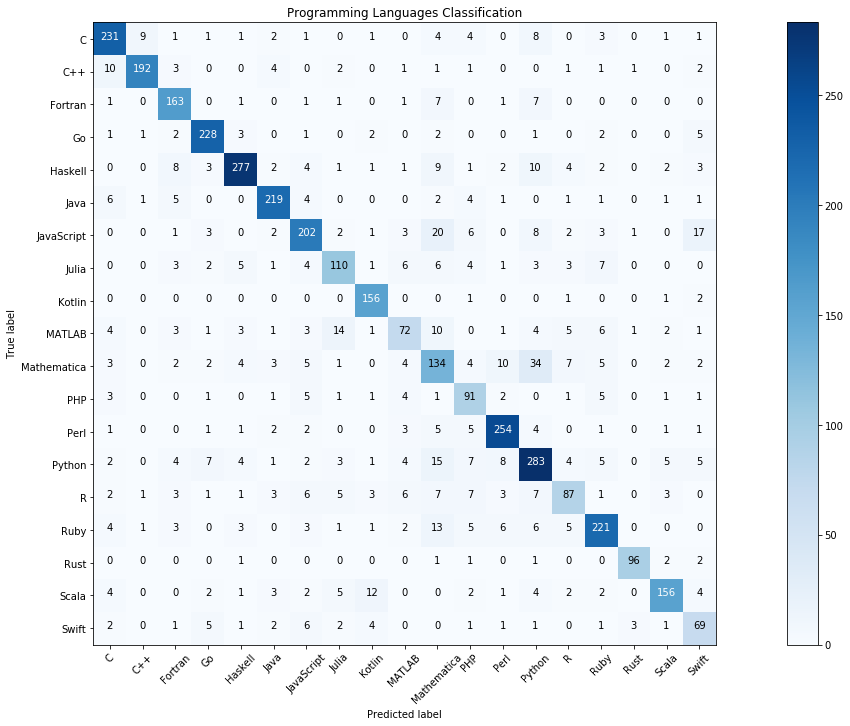


Experiment name: naive_bayes_tfidf_maxfeatures10000_mindf15_ngram11
 - f1_score on train set: 0.8453309006468734
 - f1_score on test set: 0.7715849713859169


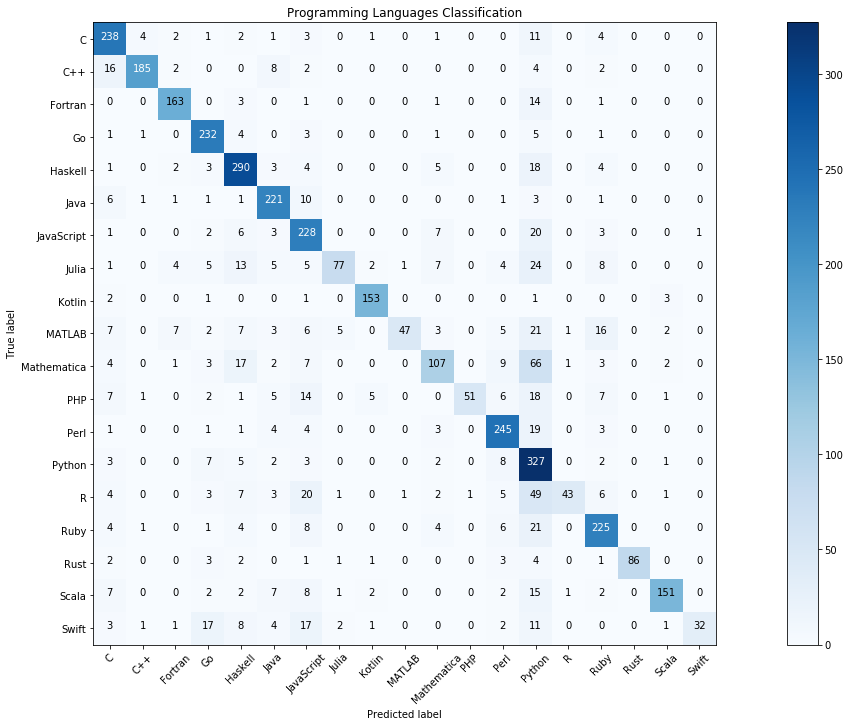


Experiment name: logistic_regression_cv_maxfeatures10000_mindf5_ngram11
 - f1_score on train set: 0.9664952728479018
 - f1_score on test set: 0.8636476735506345


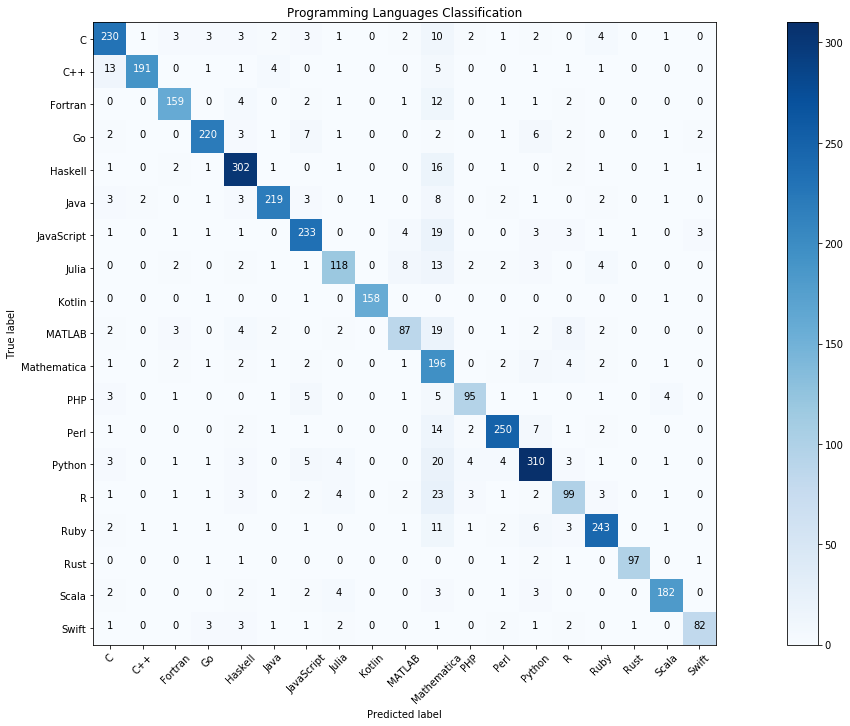


Experiment name: logistic_regression_tfidf_maxfeatures10000_mindf15_ngram11
 - f1_score on train set: 0.9047934980925527
 - f1_score on test set: 0.847723314257278


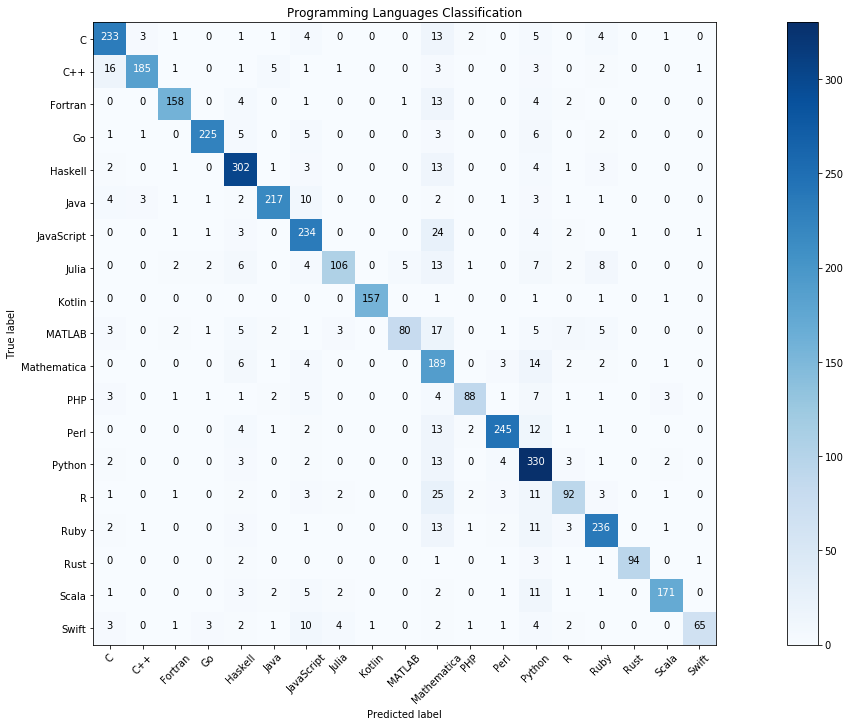


Experiment name: bagging_cv_maxfeatures10000_mindf5_ngram11
 - f1_score on train set: 0.9906286282965666
 - f1_score on test set: 0.8405075889524758


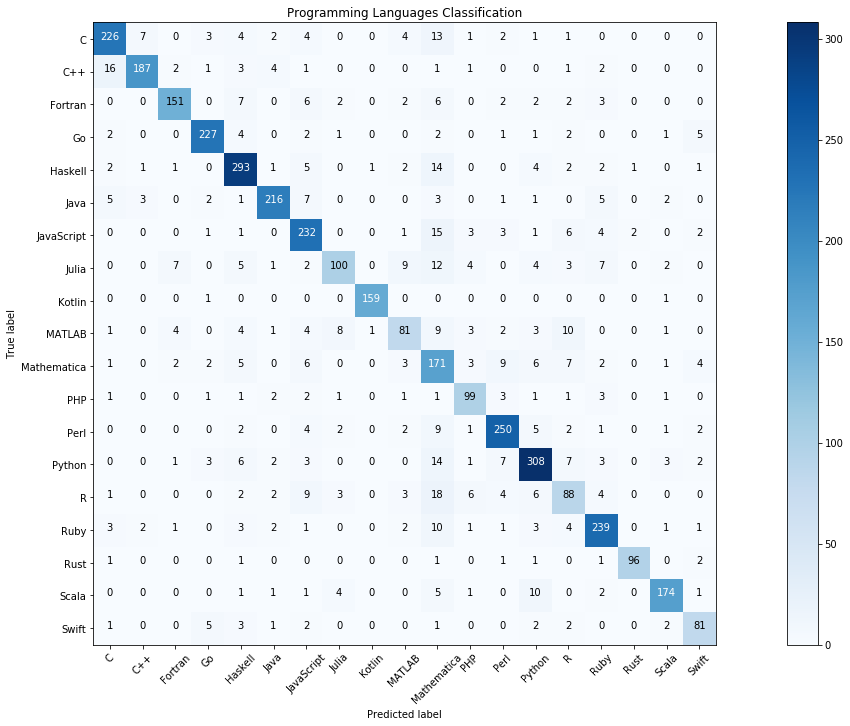


Experiment name: bagging_tfidf_maxfeatures10000_mindf15_ngram11
 - f1_score on train set: 0.9860673411842759
 - f1_score on test set: 0.8405075889524758


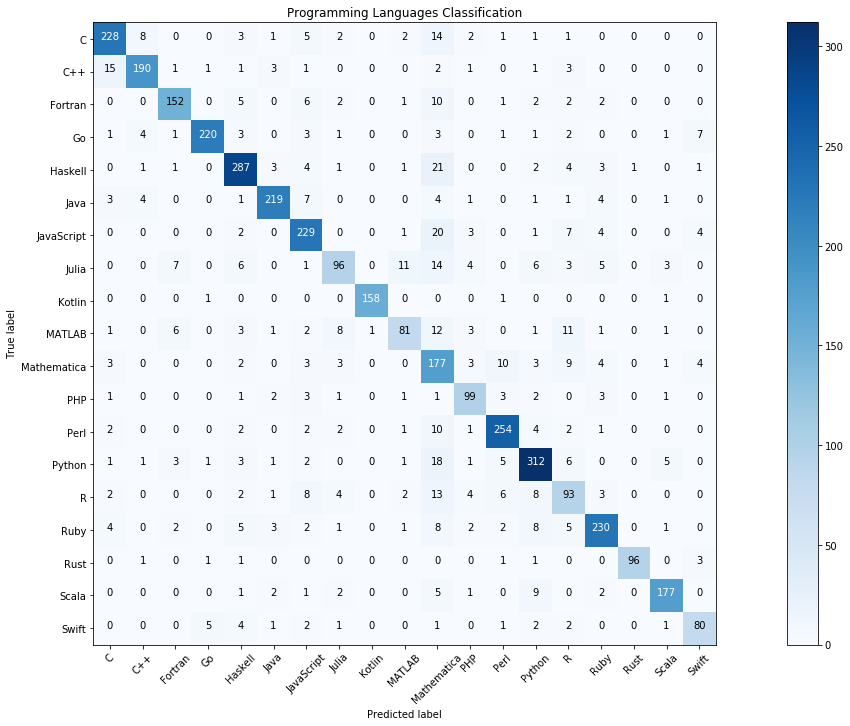


Experiment name: random_forests_cv_maxfeatures10000_mindf5_ngram11
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.6min finished


 - best parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False)
 - f1_score on train set: 0.8926024216287941
 - f1_score on test set: 0.8551878576760388


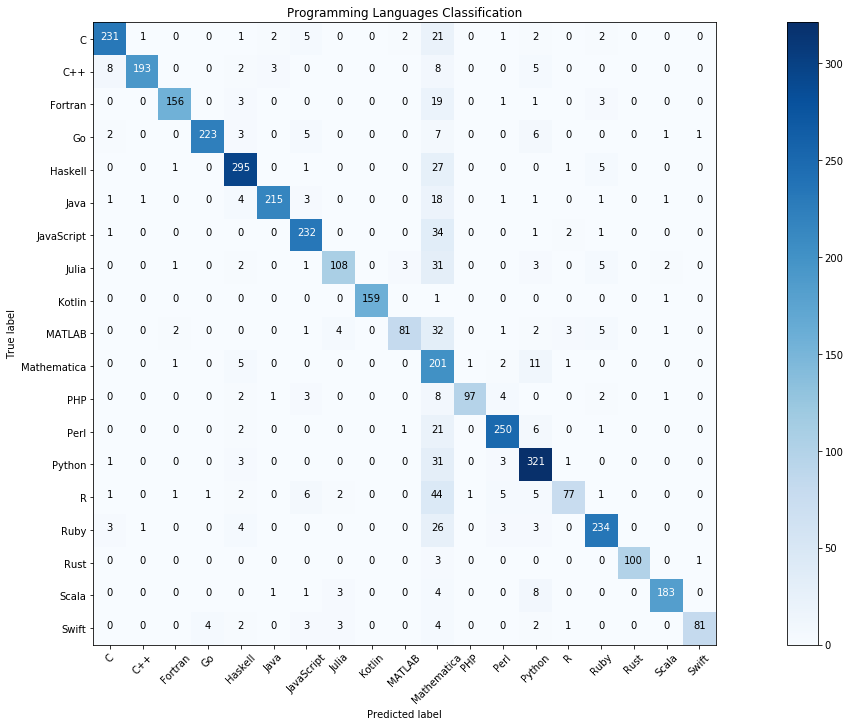


Experiment name: random_forests_cv_maxfeatures10000_mindf15_ngram11
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  3.8min finished


 - best parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False)
 - f1_score on train set: 0.9001492784873113
 - f1_score on test set: 0.8564319482458322


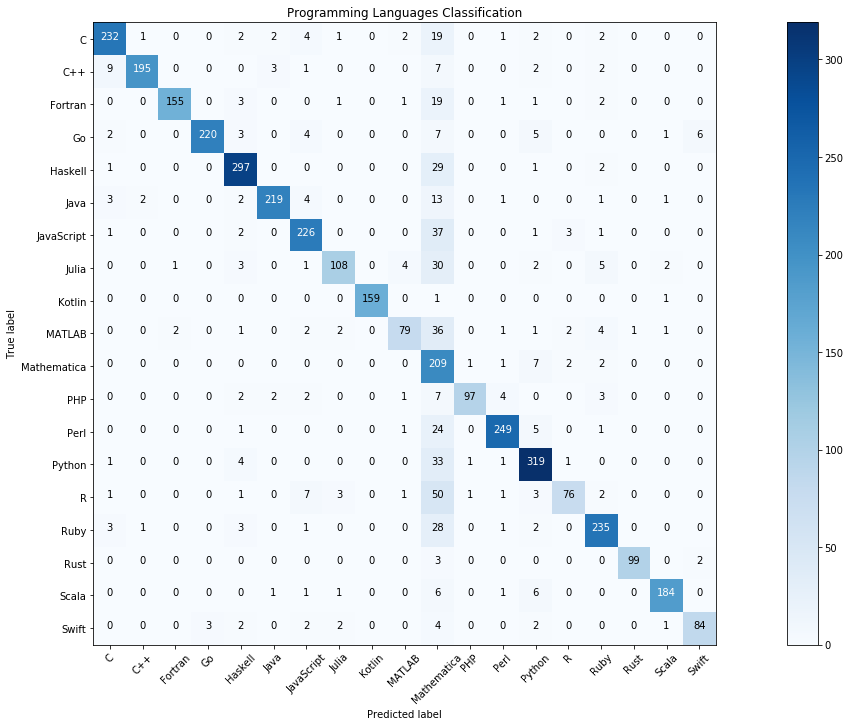


Experiment name: random_forests_cv_maxfeatures10000_mindf15_ngram13
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.0min finished


 - best parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False)
 - f1_score on train set: 0.8709570409686516
 - f1_score on test set: 0.8432445882060214


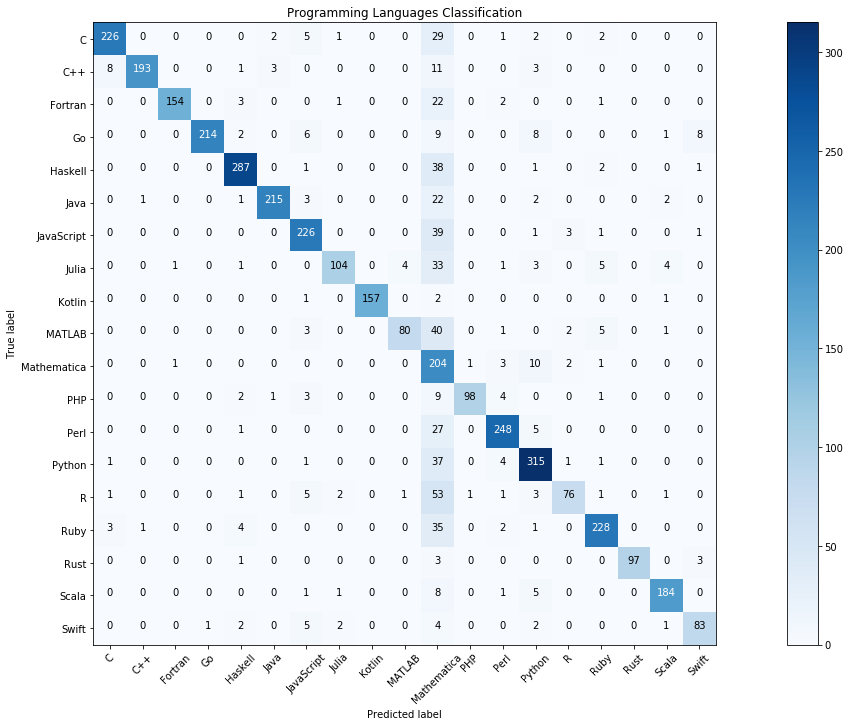


Experiment name: random_forests_tfidf_maxfeatures10000_mindf5_ngram11
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.9min finished


 - best parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False)
 - f1_score on train set: 0.8969149112622326
 - f1_score on test set: 0.854192585220204


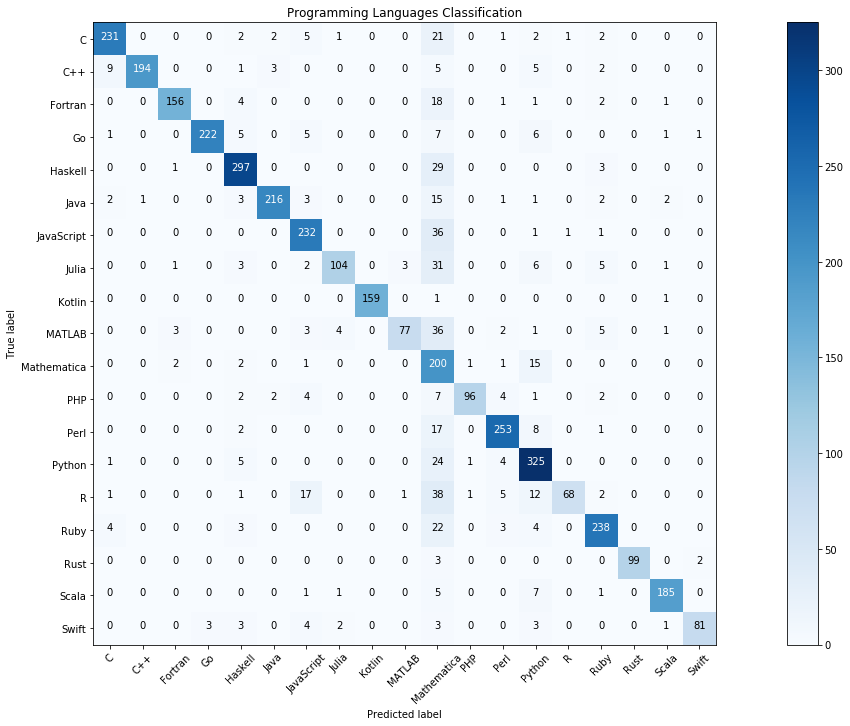


Experiment name: lgbm_cv_maxfeatures10000_mindf5_ngram11
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 25.5min finished


 - best parameters: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=20, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
 - f1_score on train set: 0.9723834798474043
 - f1_score on test set: 0.8798208509579497


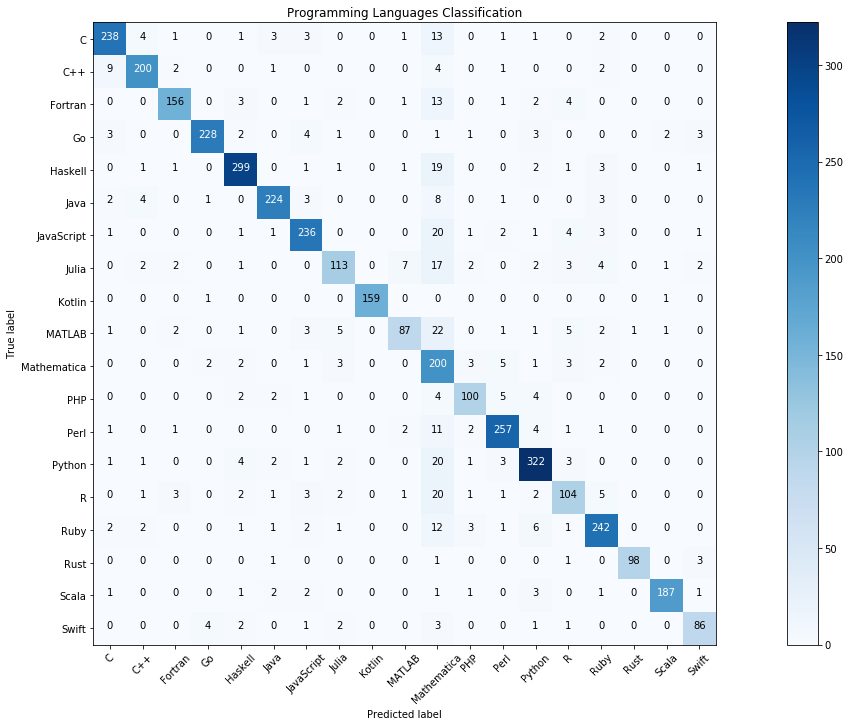


Experiment name: lgbm_cv_maxfeatures10000_mindf15_ngram11
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 25.8min finished


 - best parameters: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=20, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
 - f1_score on train set: 0.9723834798474043
 - f1_score on test set: 0.8798208509579497


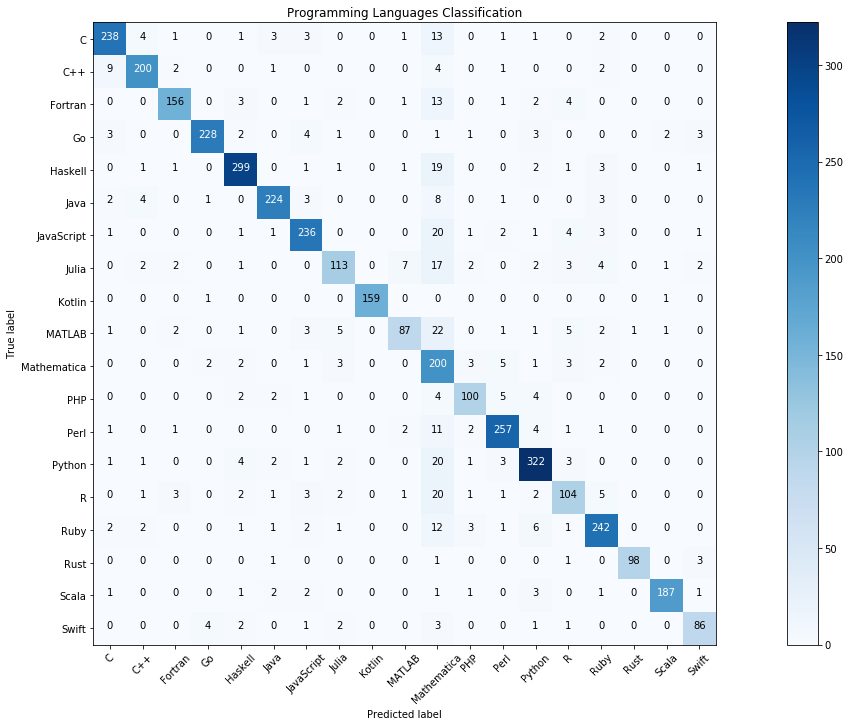


Experiment name: lgbm_cv_maxfeatures10000_mindf5_ngram13
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 32.1min finished


 - best parameters: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=23, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
 - f1_score on train set: 0.97528611710068
 - f1_score on test set: 0.8805673052998259


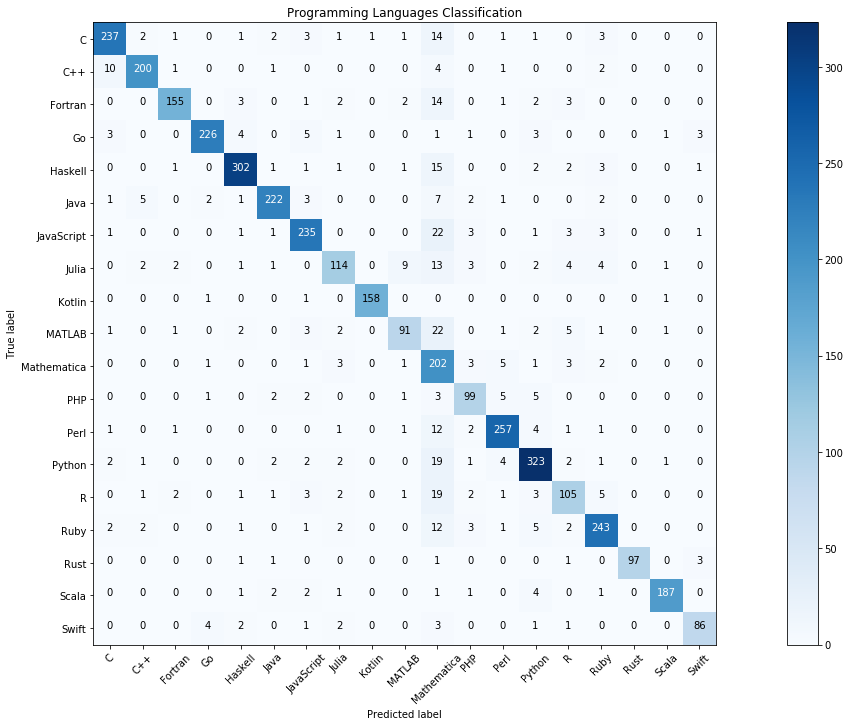


Experiment name: lgbm_cv_maxfeatures10000_mindf15_ngram13
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 32.6min finished


 - best parameters: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=23, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
 - f1_score on train set: 0.97528611710068
 - f1_score on test set: 0.8805673052998259


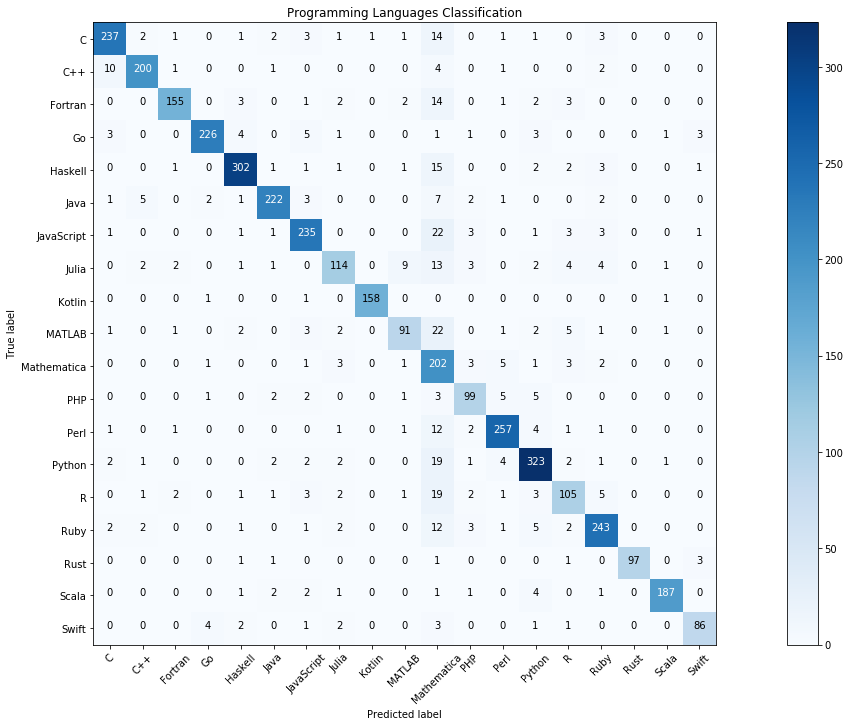


Experiment name: lgbm_tfidf_maxfeatures10000_mindf5_ngram11
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 35.7min finished


 - best parameters: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=15, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
 - f1_score on train set: 0.9743738596782219
 - f1_score on test set: 0.8775814879323215


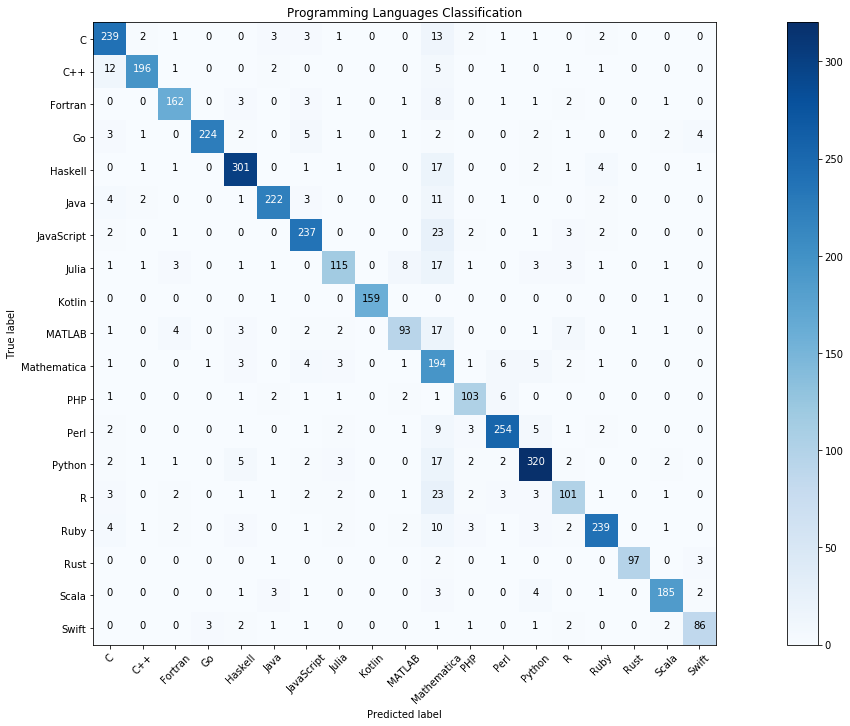

In [9]:
df_data = load(DATA_DIR, CHALLENGE_DATA_FILENAME)
df_data_copy = df_data.copy()

for e in experiment_space:
    print("Experiment name: {}".format(e["name"]))
    
    preprocess = e["preprocessing_function"]
    train_and_predict = e["evaluating_function"]

    X_train, y_train, X_test, y_test = preprocess(
        df_data_copy, e["text_feature"], e["target_feature"], 
        e["label_encoder"], e["tokenizer"]
    )
    
    result_model = train_and_predict(
        X_train, y_train, X_test, y_test, e["model_template"], e["metric"],
        e["optimization"], e["param_space"], e["confusion_matrix"],
        e["label_encoder"]
    )
    
    e["result"] = result_model
    
    print()

### Picking model

In [17]:
picked_space = None

In [18]:
picked_space_name = "random_forests_cv_maxfeatures10000_mindf15_ngram11"
for space in experiment_space:
    if space["name"] == picked_space_name:
        picked_space = space

In [19]:
model = picked_space["result"]
tokenizer = picked_space["tokenizer"]
label_encoder = picked_space["label_encoder"]

### Test

In [20]:
test_python = ["""
import random as rnd

random_numbers = list()
for i in range(100):
    random_number = rnd.randint(1, 100)
    random_numbers.add(random_number)
    
for i, number in enumerate(random_numbers):
    print("No. {}: {}".format(i, number))
"""]

tokenized = tokenizer.transform(test_python)
prediction = model.predict(tokenized)
print(prediction, label_encoder.inverse_transform(prediction))

[13] ['Python']


In [21]:
test_cpp = ["""
#import <iostream>

int main() {
    println("Hello World!")
    return 0;
}
"""]

tokenized = tokenizer.transform(test_cpp)
prediction = model.predict(tokenized)
print(prediction, label_encoder.inverse_transform(prediction))

[1] ['C++']


### Saving model

In [22]:
model_filepath = "./{}.pkl".format(picked_space_name)

In [23]:
save_sklearn_model(Pipeline([('tokenizer', tokenizer), ('model', model)]), model_filepath)

### Loading Test

In [25]:
loaded_model = load_sklearn_model(model_filepath)
pred_python = loaded_model.predict(test_python)
pred_cpp = loaded_model.predict(test_cpp)
print(pred_python, label_encoder.inverse_transform(pred_python))
print(pred_cpp, label_encoder.inverse_transform(pred_cpp))

[13] ['Python']
[1] ['C++']
